## Transform data into larger chunks of around 500 tokens
This assumes that the dataset is ordered sequentially. If this is not the case, then this part should be skipped

In [1]:
!pip install openai pandas transformers sklearn

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2342 sha256=ef8cf7e26451bc563b9ce480c4402eb42fd8d2e41989e47a6a497ba11cd83a92
  Stored in directory: /home/jupyter/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [2]:
import pandas as pd
import openai
import os

openai.api_key = os.environ['OPENAI_KEY']  # beta.openai.com/login/

hf = pd.read_json('data/huggingface-qa.jsonl', lines=True)
pt = pd.read_json('data/pytorch-qa.jsonl', lines=True)
tf = pd.read_json('data/tensorflow-qa.jsonl', lines=True)
sl = pd.read_json('data/streamlit-qa.jsonl', lines=True)
df = pd.concat([hf, pt, tf, sl], ignore_index=True)
df.sample(5)

,docs,category,thread,href,question,context,marked
4852,tensorflow,General Discussion,What OS do you primarily use TensorFlow on?,https://discuss.tensorflow.org/t/what-os-do-yo...,What operating system do you use TensorFlow on...,I’d add Colab as an option (or maybe the Brows...,0
1475,huggingface,🤗Transformers,Modify beam search objective,https://discuss.huggingface.co/t/modify-beam-s...,"Hi, I would like to experiment with adding an ...",Hello! Have you find any solution? I found thi...,0
2518,huggingface,Amazon SageMaker,Hitting Deployed Endpoint *Outside* of Notebook,https://discuss.huggingface.co/t/hitting-deplo...,All the tutorials tend to end at:\npredictor.p...,"Hey @rosenjcb,\nThank you for opening this thr...",0
5172,streamlit,Using Streamlit,Multi-page apps,https://discuss.streamlit.io/t/multi-page-apps...,Is there any support for apps that have multip...,Sounds interesting for me as well.,0
1391,huggingface,Models,Cannot import newly uploaded model,https://discuss.huggingface.co/t/cannot-import...,"Hi, I imported a new model at https://huggingf...",prithvisrinivasan:\n\nfrom transformers import...,0


In [3]:
df.values[5080]

array(['streamlit', 'Using Streamlit',
       '50MB dataset limitation when using Plotly.py',
       'https://discuss.streamlit.io/t/50mb-dataset-limitation-when-using-plotly-py/9464',
       'Hi there,\nI’m using Plotly.py to show figures in my Streamlit app with big datasets. And now I get a notification of dataset oversizing, bigger than 50.0MB, is there anyway to solve this?',
       'Thanks for the reply! I found this github link before I posted this issue, but it didn’t solve my problem.\nBut later my friends and I found this error message in ~/site-packages/streamlit/server/server_util.py, and changed the parameter MESSAGE_LIMIT_SIZE to 200*1e6, making the write limit now 200 MB',
       1], dtype=object)

In [4]:
df.docs.value_counts()

huggingface    2765
tensorflow     1224
streamlit      1115
pytorch        1061
Name: docs, dtype: int64

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1718 > 1024). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<AxesSubplot: >

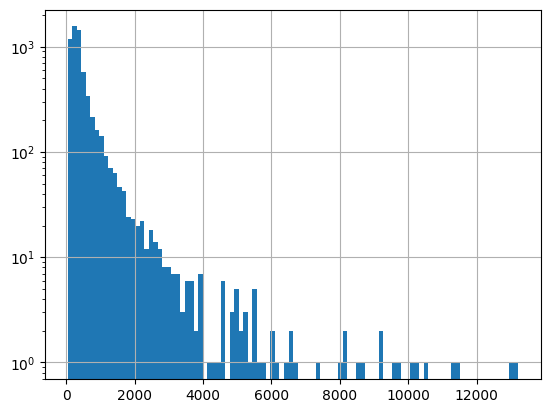

In [5]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ', regex=False)
    serie = serie.str.replace('\\n', ' ', regex=False)
    serie = serie.str.replace('  ',' ', regex=False)
    serie = serie.str.replace('  ',' ', regex=False)
    return serie


from transformers import GPT2TokenizerFast

df['text'] = "Topic: " + df.docs + " - " + df.category + "; Question: " + df.thread + " - " + df.question + "; Answer: " + df.context
df['text'] = remove_newlines(df.text)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df.n_tokens.hist(bins=100, log=True)

<AxesSubplot: >

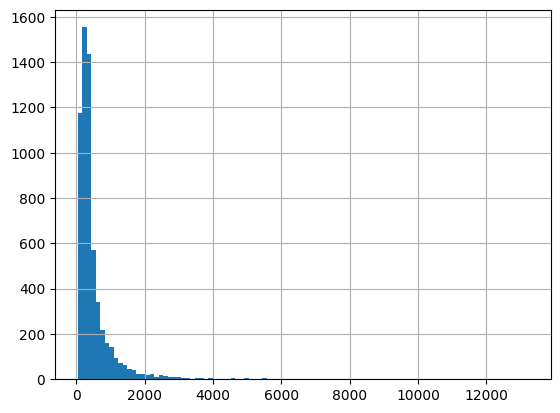

In [6]:
df.n_tokens.hist(bins=100)

In [7]:
df = df[df.n_tokens < 2000]

Verify that the get_embedding function works

In [8]:
size = 'curie'

from openai.embeddings_utils import get_embedding
from tqdm import tqdm

test_embedding = get_embedding("hello world")

print(test_embedding)

[-0.0028790077194571495, 0.015384349972009659, -0.014927011914551258, -0.006415438838303089, -0.0077938055619597435, 0.009667621925473213, -0.008918095380067825, -0.005719903856515884, 0.008994318544864655, -0.00473853200674057, -0.00848616473376751, 0.005040248390287161, 0.003903254633769393, -0.0007324557518586516, -0.007139557972550392, -0.004262138158082962, -0.006005740258842707, -0.007272948045283556, -0.012633968144655228, 0.0008718009921722114, -0.0025677636731415987, 0.0016753188101574779, 0.012049592100083828, -0.000711811997462064, 0.011414400301873684, -0.0016165635315701365, 0.013415254652500153, -0.0008694190182723105, -0.007768397685140371, 0.001943687442690134, -0.012621264904737473, -0.005846942309290171, 0.0010067792609333992, -0.005373724270612001, -0.011306417174637318, -0.0005105355521664023, 0.0128880450502038, 0.0016435591969639063, 0.004547974560409784, 0.012513281777501106, -0.010925302281975746, 0.0007602453697472811, -0.0011496974620968103, -0.011846330016851

## Get Embeddings, and save them

In [9]:
# size = 'curie'

# from openai.embeddings_utils import get_embedding
# from tqdm import tqdm

# print("hello 0")



#     df['embeddings'] = df.text.apply(lambda x: get_embedding(x, engine=f'text-search-{size}-doc-001'))
    
# print("hello 0.5")

# with tqdm(total=len(df)) as pbar:
#     df.to_parquet('data/curie_embeddings.parquet', progress_bar=pbar)

# print("hello 1")

# df.head()

# print("hello 2")